In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# import empyrical as emp
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
# print(NASDAQ100)
# NASDAQ100 = ['NDX', 'TSLA', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'BIDU', 'FB', 'JD']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

stock_df_dict = {}

# for symbol in ['EOS', 'BITCOIN', 'STELLAR']:
for symbol in CRYPTOCURRENCY:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
    stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df


Wall time: 11.6 s


In [3]:
df = stock_df_dict['EOS'].copy()
df = df.drop(columns='pct_change')
df['ROLLING_30_MAX'] = df['close'].rolling(30).max()
df['ROLLING_10_MIN'] = df['close'].rolling(10).min()
df.reset_index(drop=False, inplace=True)
df = df.astype(dtype={'date': 'datetime64[ns]'})
df.set_index('date', inplace=True)
# df.index.astype()
display_charts(df, chart_type='stock', title='EOS', use_index=True, figsize = (900, 700))

In [11]:
%%time
# %xmode

### Turtle

START_MONEY = 10000
PROPERTY = START_MONEY
CASH = START_MONEY
BUY_SUM = 0
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2017-07-01'
start_date = '2018-02-01'
end_date = '2018-08-12'

yesterday = None

show_df = None
show_df = stock_df_dict['EOS'].copy()
show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan
show_df['ops_T'] = ''
show_df['reason_T'] = ''
show_df['count_T'] = 0

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['EOS'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        N = 10
        try:
            is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == (stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min()).loc[today])
        except:
            print(stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min())
            raise 'FUCK'
#         print(is_sell)
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 退出 SELL %s * %d @ %f PROPERTY=%d' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], PROPERTY))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            
            show_df.loc[today, 'ops_T'] = 'SELL'
            show_df.loc[today, 'reason_T'] = 'WIN'
            show_df.loc[today, 'count_T'] = show_df.loc[today, 'count_T'] + order[2]
    
#     for symbol in ['EOS']:
    for symbol in CRYPTOCURRENCY:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        try:
            # turtle buy N days
            N = 30
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[today])

            if is_buy:
#                 if CASH < 1000:
#                     continue
#                 buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
                buy = int(CASH / stock_df_dict[symbol].loc[today, 'close'])
                if buy == 0:
#                     buy = int(1000 / stock_df_dict[symbol].loc[today, 'close'])
                    pass
#                     if buy != 0:
#                         CASH += 1000
#                         BUY_SUM += 1000
#                     continue
                CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#                 hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
                hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
                print('%s 进场 BUY  %s * %d @ %f PROPERTY=%d' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], PROPERTY))
                recode_df = recode_df.append(
                    {
                        'date': today,
                        'ops': 'BUY',
                        'reason': 'ENTER',
                        'symbol': symbol,
                        'count': buy,
                        'price': stock_df_dict[symbol].loc[today, 'close'],
                        'buy_price': stock_df_dict[symbol].loc[today, 'close'],
    #                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                        'expect': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
            
                show_df.loc[today, 'ops_T'] = 'BUY'
                show_df.loc[today, 'reason_T'] = 'ENTER'
                show_df.loc[today, 'count_T'] = buy
        except:
            print(symbol, today, 'FUCK')
            raise 'FUCK'
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(BUY_SUM)
print(PROPERTY)
print(PROPERTY / (START_MONEY + BUY_SUM))

s_p = stock_df_dict['EOS'].loc[start_date, 'close']
e_p = stock_df_dict['EOS'].loc[end_date, 'close']
print('EOS', s_p, e_p, e_p / s_p)


2018-02-14 进场 BUY  LITECOIN * 46 @ 213.360000 PROPERTY=10000
2018-02-15 进场 BUY  LITECOIN * 0 @ 225.430000 PROPERTY=10555
2018-02-16 进场 BUY  LITECOIN * 0 @ 230.120000 PROPERTY=10770
2018-02-20 进场 BUY  LITECOIN * 0 @ 232.850000 PROPERTY=10896
2018-03-03 进场 BUY  BITCOIN * 0 @ 11489.700000 PROPERTY=9874
2018-03-04 进场 BUY  BITCOIN * 0 @ 11512.600000 PROPERTY=10020
2018-03-05 进场 BUY  BITCOIN * 0 @ 11573.300000 PROPERTY=9899
2018-03-06 退出 SELL LITECOIN * 46 @ 196.600000 PROPERTY=9229
2018-03-06 退出 SELL LITECOIN * 0 @ 196.600000 PROPERTY=9229
2018-03-07 退出 SELL LITECOIN * 0 @ 185.840000 PROPERTY=9229
2018-03-07 退出 SELL BITCOIN * 0 @ 9965.570000 PROPERTY=9229
2018-03-07 退出 SELL BITCOIN * 0 @ 9965.570000 PROPERTY=9229
2018-03-08 退出 SELL LITECOIN * 0 @ 176.510000 PROPERTY=9229
2018-03-09 退出 SELL BITCOIN * 0 @ 9337.550000 PROPERTY=9229
2018-04-11 进场 BUY  EOS * 1087 @ 8.490000 PROPERTY=9229
2018-04-12 进场 BUY  EOS * 0 @ 8.700000 PROPERTY=9457
2018-04-13 进场 BUY  EOS * 0 @ 8.740000 PROPERTY=9500
2018-

In [5]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

# start_date = '2017-07-02'
# start_date = '2018-01-01'
# end_date = '2018-05-23'

yesterday = None

# show_df = None
# show_df = stock_df_dict['399300'].copy()
show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['EOS'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[today, 'close']) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 盈利 SELL %s * %d @ %f EXPECT %f PROPERTY=%d' % 
                  (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], order[4], PROPERTY))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[3] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 止损 SELL %s * %d @ %f EXPECT %f PROPERTY=%d' % 
                  (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], order[4], PROPERTY))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 超时 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in ['EOS']:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.1)
           
        if is_buy:
            if stock_df_dict[symbol].loc[today, 'close'] < stock_df_dict[symbol].shift(7).loc[today, 'close']:
                continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].shift(1).loc[today, 'close'])])
            print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].shift(1).loc[today, 'close'])))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': float(stock_df_dict[order[1]].shift(1).loc[today, 'close']),
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[today, 'close']) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

s_p = stock_df_dict['EOS'].loc[start_date, 'close']
e_p = stock_df_dict['EOS'].loc[end_date, 'close']
print('EOS', s_p, e_p, e_p / s_p)


2018-04-30 进场 BUY  EOS * 568 @ 17.580000 EXPECT 9419.080000
2018-05-15 止损 SELL EOS * 568 @ 12.990000 EXPECT 9419.080000 PROPERTY=97392
97392.88
[]
97392.88
EOS 10.21 5.01 0.49069539667
Wall time: 464 ms


In [6]:
show_df = show_df.dropna(how='any', inplace=False)
show_df = show_df.astype(dtype={'CASH_T': 'int64', 'PROPERTY_T': 'int64'})
# show_df
# show_df.dtypes

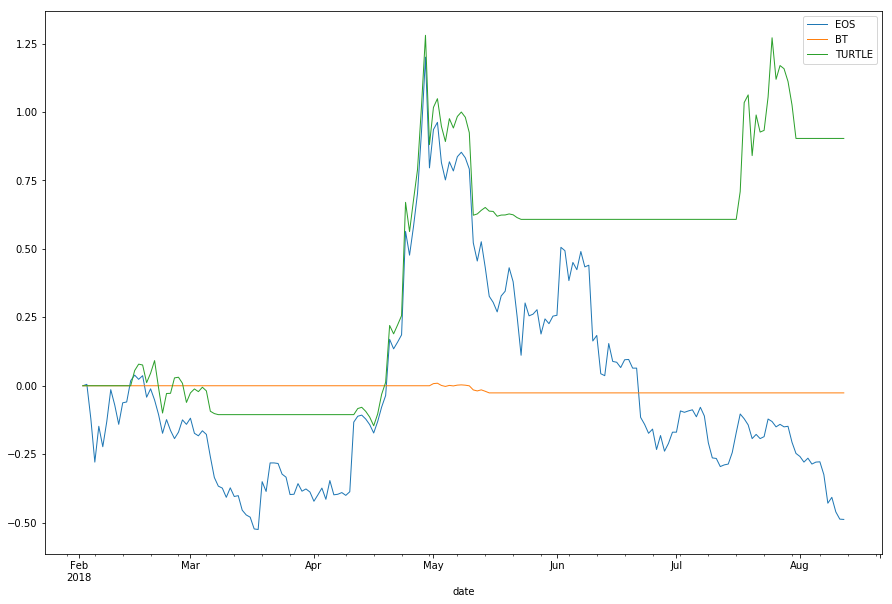

In [7]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False)
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# stock_df_dict['NDX']

ax = df.plot(kind='line', y='close', label='EOS', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='BT', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', label='TURTLE', secondary_y=False, linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()

In [8]:
# chart = serialize(df=df, title="DF", use_index=True, output_type='json')
# display_charts(chart)
display_charts(df=df.loc[:, ['PROPERTY', 'PROPERTY_T', 'close']], chart_type="stock", title="DF", use_index=True, figsize = (900, 700))